1.import libraries and load datasets

In [179]:
#import libraries to load the data
import pandas as pd
import numpy as np
#load the dataframe into the variables
fear_greed=pd.read_csv("fear_greed_index.csv")
historical_data=pd.read_csv("historical_data.csv")
#checking whether the data is loaded or not  


In [180]:
#clean teh columns by using the strip and lower
historical_data.columns = historical_data.columns.str.strip().str.lower()
fear_greed.columns = fear_greed.columns.str.strip().str.lower()
print(fear_greed.head())
print(historical_data.head())

    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
                                      account  coin  execution price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size tokens  size usd side     timestamp ist  start position direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50 

In [181]:
fear_greed["classification"] = fear_greed["classification"].str.lower()
fear_greed["classification"] = fear_greed["classification"].replace({
    "extreme fear":"fear",
    "extreme greed":"greed"
})
fear_greed = fear_greed[fear_greed["classification"] != "neutral"]


In [182]:
#printing the number of rows and columns

In [183]:
#printing the shape of the feer_greed data it gives us number  of rows and number of columns
print("number of rows and number of columns",fear_greed.shape)
#printing the shape of the historica_data data it gives us number  of rows and number of columns
print("number of rows and number of columns",historical_data.shape)


number of rows and number of columns (2644, 4)
number of rows and number of columns (211224, 16)


In [184]:
##missing values / duplicates

In [185]:
# missing and duplicate values of both the data sets
print("missing values of fear_greed data set:",fear_greed.isna().sum())
print("missing values of historical_data data set:",historical_data.isna().sum())
print("duplicate  values of fear_greed data set:",fear_greed.duplicated().sum())
print("duplicate values of historical_data data set:",historical_data.duplicated().sum())

missing values of fear_greed data set: timestamp         0
value             0
classification    0
date              0
dtype: int64
missing values of historical_data data set: account             0
coin                0
execution price     0
size tokens         0
size usd            0
side                0
timestamp ist       0
start position      0
direction           0
closed pnl          0
transaction hash    0
order id            0
crossed             0
fee                 0
trade id            0
timestamp           0
dtype: int64
duplicate  values of fear_greed data set: 0
duplicate values of historical_data data set: 0


In [186]:
#extracting the date from the time stamp
historical_data["timestamp"] = pd.to_datetime(historical_data["timestamp"], unit="ms")
historical_data["date"] = historical_data["timestamp"].dt.date


In [187]:
#removing the unwanted coumns 
fear_greed["date"] = pd.to_datetime(fear_greed["date"]).dt.date

fear_greed=fear_greed[["date","classification"]]
historical_data=historical_data[["account","coin","side","size usd","closed pnl","fee","date"]]
#merging the datasets into one merged_data
merged_data=historical_data.merge(fear_greed,on='date',how='left')
merged_data = merged_data.dropna(subset=["classification"])

#shape of the merged_data
print(merged_data.shape)

(184263, 8)


In [188]:
#first we have to group the same date then sum the closed pnl
daily_pnl = merged_data.groupby(["account","date"])["closed pnl"].sum().reset_index()
daily_pnl.rename(columns={"closed pnl":"daily_pnl"}, inplace=True)
merged_data=merged_data.merge(daily_pnl,on=["account","date"],how='left')


In [189]:
#trade frequency
merged_data.groupby("classification")["account"].count()


classification
fear       133871
greed       43251
neutral      7141
Name: account, dtype: int64

In [190]:
#trade size average
merged_data.groupby('classification')['size usd'].mean()


classification
fear       5259.977837
greed      3581.661513
neutral    3058.848110
Name: size usd, dtype: float64

In [191]:
#long vs short
pd.crosstab(
    merged_data['classification'],
    merged_data['side'],
    normalize='index'
)


side,BUY,SELL
classification,,
fear,0.493617,0.506383
greed,0.434487,0.565513
neutral,0.490828,0.509172


In [192]:
#creating the sizesegment columns high vs low 
merged_data["size_segment"] = np.where(merged_data["size usd"] > merged_data["size usd"].median(), "High_Size", "Low_Size")


In [193]:
tc=merged_data.groupby("account").size();merged_data["freq_segment"]=np.where(merged_data["account"].map(tc)>tc.median(),"Frequent","Infrequent")


In [194]:
#daily summary

daily_summary = (
    merged_data
    .groupby(["account","date","classification"])["daily_pnl"]
    .first()
    .reset_index()
)

daily_summary["daily_win"] = daily_summary["daily_pnl"] > 0
segment_info = merged_data[["account","size_segment","freq_segment"]].drop_duplicates()
daily_summary = daily_summary.merge(segment_info, on="account", how="left")


In [195]:
#average daily pnl
avg_daily_pnl = daily_summary.groupby("classification")["daily_pnl"].mean()
print(avg_daily_pnl)


classification
fear       209372.662205
greed       90988.703436
neutral     19842.797260
Name: daily_pnl, dtype: float64


In [196]:
#win rate
win_rate=daily_summary.groupby("classification")["daily_win"].mean()
print(win_rate)


classification
fear       0.937500
greed      0.783784
neutral    0.500000
Name: daily_win, dtype: float64


In [197]:
#drawdown 
drawdown_proxy=daily_summary.groupby("classification")["daily_pnl"].apply(lambda x: (x < 0).mean())
print(drawdown_proxy)


classification
fear       0.062500
greed      0.081081
neutral    0.500000
Name: daily_pnl, dtype: float64


In [198]:
#size_segment
daily_summary.groupby(["classification","size_segment"])["daily_pnl"].mean()


classification  size_segment
fear            High_Size       362121.893951
                Low_Size        286650.349957
greed           High_Size       224372.874855
                Low_Size        272429.492851
neutral         High_Size         2784.529945
                Low_Size         14958.370508
Name: daily_pnl, dtype: float64

In [199]:
#freq_segment
daily_summary.groupby(["classification","freq_segment"])["daily_pnl"].mean()


classification  freq_segment
fear            Frequent        351641.535116
                Infrequent      135763.566289
greed           Frequent        263978.280564
                Infrequent       53006.087682
neutral         Frequent          5029.457172
                Infrequent       95701.982050
Name: daily_pnl, dtype: float64

In [200]:
account_win_rate = daily_summary.groupby("account")["daily_win"].mean()

top_25 = account_win_rate[account_win_rate > account_win_rate.quantile(0.75)].index
bottom_25 = account_win_rate[account_win_rate < account_win_rate.quantile(0.25)].index

daily_summary["consistency_segment"] = daily_summary["account"].apply(
    lambda x: "Consistent" if x in top_25 else ("Inconsistent" if x in bottom_25 else "Average")
)


In [201]:
#consistency segment
daily_summary.groupby(["classification","consistency_segment"])["daily_pnl"].mean()


classification  consistency_segment
fear            Average                154934.299932
                Inconsistent           445272.232058
greed           Average                130532.006055
                Inconsistent           -15778.213635
neutral         Average                 30753.021603
                Inconsistent           -12887.875770
Name: daily_pnl, dtype: float64

<Axes: title={'center': 'Average Daily PnL by Sentiment'}, xlabel='classification'>

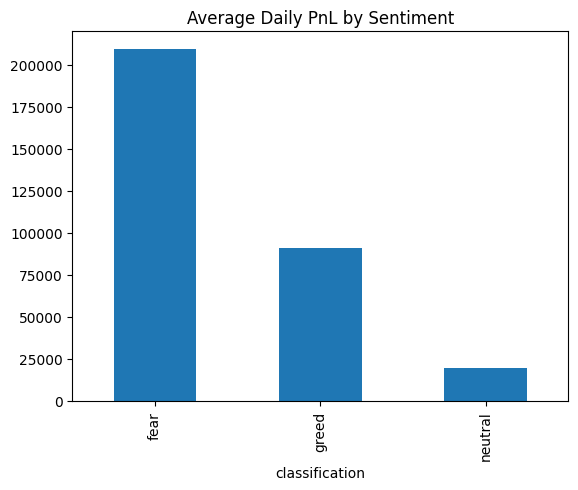

In [202]:
#ploting the average daily pnl 
avg_daily_pnl.plot(kind="bar", title="Average Daily PnL by Sentiment")


<Axes: title={'center': 'Win Rate by Sentiment'}, xlabel='classification'>

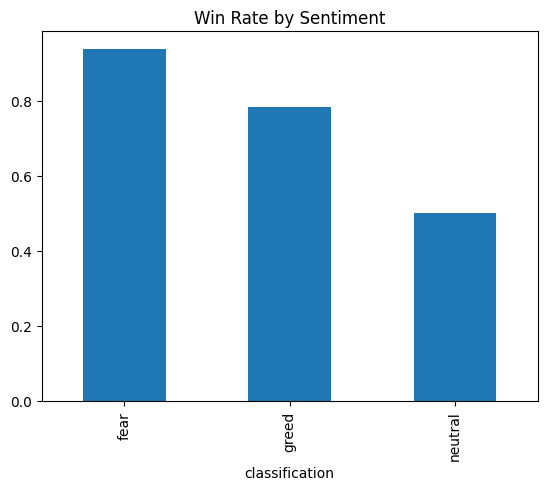

In [203]:
#plottong the winrate
win_rate.plot(kind="bar", title="Win Rate by Sentiment")


<Axes: title={'center': 'Average Trade Size by Sentiment'}, xlabel='classification'>

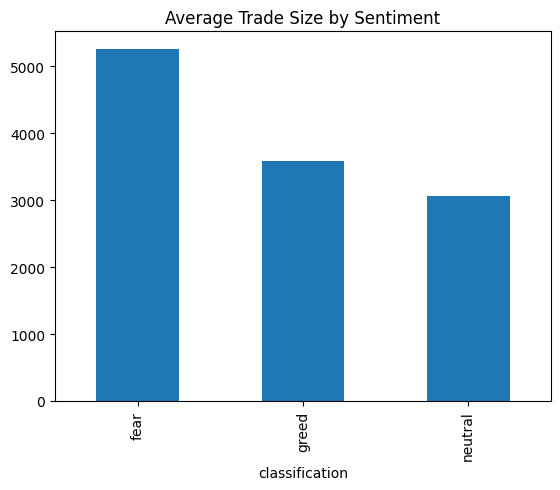

In [204]:
#plottingg the average trade
merged_data.groupby("classification")["size usd"].mean().plot(kind="bar", title="Average Trade Size by Sentiment")


#insight1
Compare daily pnl + win rate
#insight 2
Explain behavior change 
#insight 3
explain segment difference

In [205]:
print(daily_summary["classification"].value_counts())
print(daily_summary["date"].min(), daily_summary["date"].max())


classification
greed      37
fear       32
neutral     8
Name: count, dtype: int64
2023-03-28 2025-02-19
